In [1]:
# Nhập thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

import warnings
warnings.filterwarnings('ignore')

# Đọc bộ dữ liệu
corpus = pd.read_csv('data/cleaned_mhc.csv')

# Chuẩn bị dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    corpus['text'],
    corpus['label'],
    test_size=0.2,
    random_state=42
)

tfidf = TfidfVectorizer(max_features=3500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

n_components = 100

lsa = TruncatedSVD(n_components=n_components, random_state=42)
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

print(f"TF-IDF - Train shape: {X_train_tfidf.shape}, Test Shape: {X_test_tfidf.shape}")
print(f"LSA - Train shape: {X_train_lsa.shape}, Test Shape: {X_test_lsa.shape}")

TF-IDF - Train shape: (18592, 3500), Test Shape: (4648, 3500)
LSA - Train shape: (18592, 100), Test Shape: (4648, 100)


In [13]:
import time
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the range of C values to test
C_values = [0.01, 0.1, 1, 10, 100]

# Define the range of gamma values to test
gamma_values = [0.001, 0.01, 0.1, 1, 10]

def evaluate_model(X_train, X_test, y_train, y_test, dataset_name):
    # Prepare a table to store results
    metrics_table = []

    for C in C_values:
        # Initialize the model with the current C value
        model = LinearSVC(C=C, random_state=42, max_iter=10000)

        # Fit the model and record training time
        start_fit = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_fit

        # Record testing time for predictions
        start_test = time.time()
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        test_time = time.time() - start_test

        # Compute metrics
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        precision = precision_score(y_test, y_pred_test, average='weighted')
        recall = recall_score(y_test, y_pred_test, average='weighted')
        f1 = f1_score(y_test, y_pred_test, average='weighted')

        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred_test)

        print(f"Confusion Matrix for {dataset_name} (C={C}):")
        print(conf_matrix)

        # Append metrics to the table
        metrics_table.append([C, train_accuracy, test_accuracy, precision, recall, f1, fit_time, test_time])

    # Create a dataframe for the metrics
    columns = ["C", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1", "Fit Time", "Test Time"]
    metrics_df = pd.DataFrame(metrics_table, columns=columns)

    # Display the table
    print(f"\nMetrics for {dataset_name}:")
    print(metrics_df.to_string(index=False))

    return metrics_df

# Evaluate on TF-IDF dataset
tfidf_results = evaluate_model(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")

# Evaluate on LSA dataset
lsa_results = evaluate_model(X_train_lsa, X_test_lsa, y_train, y_test, "LSA")

Confusion Matrix for TF-IDF (C=0.01):
[[1909  190]
 [ 243 2306]]
Confusion Matrix for TF-IDF (C=0.1):
[[1927  172]
 [ 180 2369]]
Confusion Matrix for TF-IDF (C=1):
[[1922  177]
 [ 192 2357]]
Confusion Matrix for TF-IDF (C=10):
[[1862  237]
 [ 250 2299]]
Confusion Matrix for TF-IDF (C=100):
[[1783  316]
 [ 304 2245]]

Metrics for TF-IDF:
     C  Train Accuracy  Test Accuracy  Precision   Recall       F1  Fit Time  Test Time
  0.01        0.911252       0.906842   0.907261 0.906842 0.906933  0.036041   0.001961
  0.10        0.940512       0.924269   0.924299 0.924269 0.924281  0.046930   0.002029
  1.00        0.962188       0.920611   0.920679 0.920611 0.920635  0.059863   0.002000
 10.00        0.977786       0.895224   0.895293 0.895224 0.895252  0.085375   0.002000
100.00        0.990587       0.866609   0.866552 0.866609 0.866575  0.424543   0.002262
Confusion Matrix for LSA (C=0.01):
[[1897  202]
 [ 267 2282]]
Confusion Matrix for LSA (C=0.1):
[[1909  190]
 [ 235 2314]]
Confusion 

In [15]:
# tfidf_results = tfidf_results.drop(columns=['Fit Time', 'Test Time'])
# lsa_results = lsa_results.drop(columns=['Fit Time', 'Test Time'])

# Define desired column order
ordered_columns = [
    "C", "Train Accuracy", "Test Accuracy", "F1 Score", "Precision", "Recall"
]

tfidf_results = tfidf_results[ordered_columns].rename(columns={
    "F1": "F1 Score",
})

lsa_results = lsa_results[ordered_columns].rename(columns={
    "F1": "F1 Score",
})

# Reorder columns
tfidf_results = tfidf_results[ordered_columns]
lsa_results = lsa_results[ordered_columns]

# Style tables with heatmap, excluding the 'C' column from coloring
def style_heatmap(df, cmap):
    return df.style.applymap(lambda _: "background-color: none;", subset=['C']).background_gradient(
        cmap=cmap, subset=df.columns.difference(['C'])
    ).format(precision=3)

# Apply styles
tfidf_table_styled = style_heatmap(tfidf_results, cmap="Reds")
lsa_table_styled = style_heatmap(lsa_results, cmap="Blues")

# Display the styled tables
print("TF-IDF Results with Styled Heatmap:")
display(tfidf_table_styled)

print("\nLSA Results with Styled Heatmap:")
display(lsa_table_styled)

TF-IDF Results with Styled Heatmap:


,C,Train Accuracy,Test Accuracy,F1 Score,Precision,Recall
0,0.010,0.911,0.907,0.907,0.907,0.907
1,0.100,0.941,0.924,0.924,0.924,0.924
2,1.000,0.962,0.921,0.921,0.921,0.921
3,10.000,0.978,0.895,0.895,0.895,0.895
4,100.000,0.991,0.867,0.867,0.867,0.867



LSA Results with Styled Heatmap:


,C,Train Accuracy,Test Accuracy,F1 Score,Precision,Recall
0,0.010,0.898,0.899,0.899,0.900,0.899
1,0.100,0.909,0.909,0.909,0.909,0.909
2,1.000,0.912,0.909,0.909,0.909,0.909
3,10.000,0.912,0.910,0.910,0.910,0.910
4,100.000,0.912,0.910,0.910,0.910,0.910


Top 70 coefficients for TF-IDF model:
redflag: 2.8847
kill: 2.6053
suicidal: 2.0760
life: 1.8902
die: 1.8429
film: -1.8267
cannot: 1.5544
movie: -1.5542
depression: 1.4645
anymore: 1.4525
killing: 1.4092
pill: 1.3187
feel: 1.3019
want: 1.2188
depressed: 1.2129
end: 1.1686
alive: 1.1663
crush: -1.1315
living: 1.1034
tried: 1.0716
job: 1.0556
alone: 1.0519
que: 1.0239
yall: -1.0024
worse: 0.9874
tired: 0.9604
live: 0.9472
kinda: -0.9313
family: 0.9272
pain: 0.9203
hospital: 0.9179
rope: 0.9111
point: 0.8988
nothing: 0.8872
thought: 0.8838
death: 0.8794
done: 0.8766
suicide: 0.8675
jump: 0.8612
character: -0.8581
gun: 0.8482
ending: 0.8441
guy: -0.8420
fun: -0.8326
everything: 0.8251
cant: 0.8229
covid: -0.8164
hang: 0.8134
like: -0.8017
school: -0.8012
therapy: 0.8001
bruh: -0.7996
goodbye: 0.7821
teenager: -0.7802
tonight: 0.7741
world: 0.7736
gone: 0.7614
dead: 0.7537
minecraft: -0.7461
work: 0.7442
cut: 0.7415
way: 0.7412
enough: 0.7355
self: 0.7355
last: 0.7282
lol: -0.7276
tho: -0.7

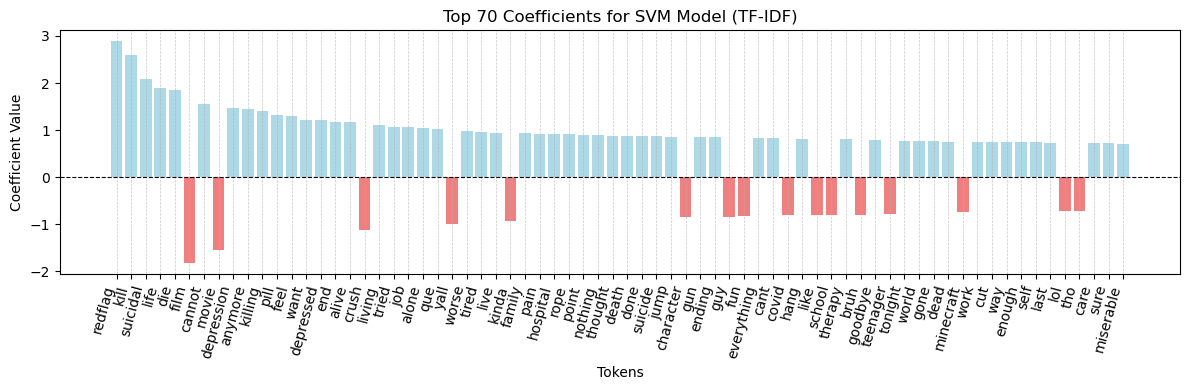

In [6]:
from sklearn.svm import LinearSVC, SVC

vis_model = LinearSVC(C=0.1, random_state=42, max_iter=10000)
vis_model.fit(X_train_tfidf, y_train)

feature_names_tfidf = tfidf.get_feature_names_out()

k = 70

coefficients_tfidf = vis_model.coef_[0]
top_k_tfidf_indices = np.argsort(np.abs(coefficients_tfidf))[-k:][::-1]
top_k_tfidf_terms = [(feature_names_tfidf[i], coefficients_tfidf[i]) for i in top_k_tfidf_indices]

print(f"Top {k} coefficients for TF-IDF model:")
for term, coef in top_k_tfidf_terms:
    print(f"{term}: {coef:.4f}")


# Extract the top-k terms based on absolute values of coefficients
top_k_tfidf_indices = np.argsort(np.abs(coefficients_tfidf))[-k:][::-1]
top_k_tfidf_terms = [(feature_names_tfidf[i], coefficients_tfidf[i]) for i in top_k_tfidf_indices]

# Prepare data for the bar chart
terms, coefs = zip(*top_k_tfidf_terms)
colors = ['lightcoral' if coef < 0 else 'lightblue' for coef in coefs]

# Plot the bar chart
plt.figure(figsize=(12, 4))
plt.bar(terms, coefs, color=colors)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xticks(rotation=75, ha='right')
plt.title(f"Top {k} Coefficients for SVM Model (TF-IDF)")
plt.xlabel("Tokens")
plt.ylabel("Coefficient Value")
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)  # Adding gridlines
plt.tight_layout()
plt.show()

In [5]:
import time
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the range of C values to test
C_values = [0.01, 0.1, 1, 10, 100]

# Define the range of gamma values to test
gamma_values = [0.001, 0.01, 0.1, 1, 10]

def evaluate_rbf_svc(X_train, X_test, y_train, y_test, dataset_name):
    # Prepare a table to store results
    metrics_table = []

    for C in C_values:
        for gamma in gamma_values:
            # Initialize the model with the current C and gamma values
            model = SVC(C=C, kernel='rbf', gamma=gamma, random_state=42)

            # Fit the model and record training time
            start_fit = time.time()
            model.fit(X_train, y_train)
            fit_time = time.time() - start_fit

            # Record testing time for predictions
            start_test = time.time()
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            test_time = time.time() - start_test

            # Compute metrics
            train_accuracy = accuracy_score(y_train, y_pred_train)
            test_accuracy = accuracy_score(y_test, y_pred_test)
            precision = precision_score(y_test, y_pred_test, average='weighted')
            recall = recall_score(y_test, y_pred_test, average='weighted')
            f1 = f1_score(y_test, y_pred_test, average='weighted')

            # Compute confusion matrix
            conf_matrix = confusion_matrix(y_test, y_pred_test)

            print(f"Confusion Matrix for {dataset_name} (C={C}, gamma={gamma}):")
            print(conf_matrix)

            # Append metrics to the table
            metrics_table.append([C, gamma, train_accuracy, test_accuracy, f1, precision, recall, fit_time, test_time])

    # Create a dataframe for the metrics
    columns = ["C", "Gamma", "Train Accuracy", "Test Accuracy", "F1", "Precision", "Recall", "Fit Time", "Test Time"]
    metrics_df = pd.DataFrame(metrics_table, columns=columns)

    # Display the table
    print(f"\nMetrics for {dataset_name}:")
    print(metrics_df.to_string(index=False))

    return metrics_df

# Evaluate RBF SVC on LSA dataset
metrics = evaluate_rbf_svc(X_train_lsa, X_test_lsa, y_train, y_test, "LSA")

Confusion Matrix for LSA (C=0.01, gamma=0.001):
[[   0 2099]
 [   0 2549]]
Confusion Matrix for LSA (C=0.01, gamma=0.01):
[[   0 2099]
 [   0 2549]]
Confusion Matrix for LSA (C=0.01, gamma=0.1):
[[   1 2098]
 [   0 2549]]
Confusion Matrix for LSA (C=0.01, gamma=1):
[[1877  222]
 [ 305 2244]]
Confusion Matrix for LSA (C=0.01, gamma=10):
[[1113  986]
 [ 129 2420]]
Confusion Matrix for LSA (C=0.1, gamma=0.001):
[[   0 2099]
 [   0 2549]]
Confusion Matrix for LSA (C=0.1, gamma=0.01):
[[   6 2093]
 [   0 2549]]
Confusion Matrix for LSA (C=0.1, gamma=0.1):
[[1913  186]
 [ 327 2222]]
Confusion Matrix for LSA (C=0.1, gamma=1):
[[1894  205]
 [ 235 2314]]
Confusion Matrix for LSA (C=0.1, gamma=10):
[[1587  512]
 [ 150 2399]]
Confusion Matrix for LSA (C=1, gamma=0.001):
[[   7 2092]
 [   0 2549]]
Confusion Matrix for LSA (C=1, gamma=0.01):
[[1913  186]
 [ 329 2220]]
Confusion Matrix for LSA (C=1, gamma=0.1):
[[1901  198]
 [ 242 2307]]
Confusion Matrix for LSA (C=1, gamma=1):
[[1902  197]
 [ 201 2

In [8]:
# Define desired column order
ordered_columns = [
    "C", "Gamma", "Train Accuracy", "Test Accuracy", "F1", "Precision", "Recall", "Fit Time", "Test Time"
]

# Rename columns
lsa_results = metrics[ordered_columns].rename(columns={
    "F1": "F1 Score",
    "Fit Time": "Fit Time (s)",
    "Test Time": "Test Time (s)"
})

# Styling function for heatmap
def style_heatmap(df, cmap_yellow, cmap_red, cmap_blue):
    return (
        df.style
        # Yellow gradient for 'C' and 'Gamma'
        .background_gradient(cmap=cmap_yellow, subset=["C", "Gamma"])
        # Blue gradient for accuracy, F1 Score, Precision, Recall
        .background_gradient(cmap=cmap_blue, subset=["Train Accuracy", "Test Accuracy", "F1 Score", "Precision", "Recall"])
        # Red gradient for time metrics
        .background_gradient(cmap=cmap_red, subset=["Fit Time (s)", "Test Time (s)"])
        # Precision formatting
        .format(precision=3)
    )

# Apply styling
lsa_table_styled = style_heatmap(lsa_results, cmap_yellow="YlOrBr", cmap_red="Reds", cmap_blue="Blues")

# Display the results
print("\nLSA Results with Styled Heatmap:")
display(lsa_table_styled)


LSA Results with Styled Heatmap:


,C,Gamma,Train Accuracy,Test Accuracy,F1 Score,Precision,Recall,Fit Time (s),Test Time (s)
0,0.010,0.001,0.543,0.548,0.388,0.301,0.548,44.557,67.694
1,0.010,0.010,0.543,0.548,0.388,0.301,0.548,48.075,69.863
2,0.010,0.100,0.544,0.549,0.389,0.752,0.549,44.065,66.870
3,0.010,1.000,0.881,0.887,0.887,0.888,0.887,32.586,50.641
4,0.010,10.000,0.753,0.760,0.747,0.794,0.760,38.606,56.069
5,0.100,0.001,0.543,0.548,0.388,0.301,0.548,47.166,65.793
6,0.100,0.010,0.546,0.550,0.391,0.753,0.550,42.857,65.930
7,0.100,0.100,0.887,0.890,0.890,0.892,0.890,27.326,44.639
8,0.100,1.000,0.908,0.905,0.905,0.906,0.905,18.947,25.383
9,0.100,10.000,0.872,0.858,0.856,0.865,0.858,23.647,35.504
